https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub

It is hevily based on tfhub and i am not particualarly a fan, too many specific data types

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras
import numpy as np

TensorFlow 2.x selected.


In [0]:
!pip install -q tensorflow-hub
!pip install -q seaborn

In [0]:
from absl import logging

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns

#Data

We will try to solve the Large Movie Review Dataset v1.0 task (Mass et al., 2011). The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as negative or positive.

In [5]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
  
  return train_df, test_df

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()


84131840/84125825 [==============================] - 5s 0us/step


,sentence,sentiment,polarity
0,Hello Mary Lou: Prom Night II starts at the Ha...,4,0
1,Saw this movie when it first came out in the 1...,1,0
2,DRACULA 2000 is a horror film that was continu...,4,0
3,Should have been titled 'Balderdash!' Little i...,2,0
4,"""How She Moves"" springs to life only when its ...",4,0


#Model
Input functions

Estimator framework provides input functions that wrap Pandas dataframes.

In [0]:
# creates a tensorflow estimators functions from pandas
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True) 

# Prediction on the whole training set.
predict_train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)


#Feature columns

TF-Hub provides a feature column that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the nnlm-en-dim128 module. For the purpose of this tutorial, the most important facts are:

    The module takes a batch of sentences in a 1-D tensor of strings as input.
    The module is responsible for preprocessing of sentences (e.g. removal of punctuation and splitting on spaces).
    The module works with any input (e.g. nnlm-en-dim128 hashes words not present in vocabulary into ~20.000 buckets).


In [0]:
embedded_text_feature_column = hub.text_embedding_column( 
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [11]:
embedded_text_feature_column

_TextEmbeddingColumn(key='sentence', module_spec_path='https://tfhub.dev/google/nnlm-en-dim128/1', trainable=False)

#Estimator

For classification we can use a DNN Classifier (note further remarks about different modelling of the label function at the end of the tutorial).

In [12]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.keras.optimizers.Adagrad(lr=0.003))


INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxvhh12bn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpxvhh12bn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


#

In [13]:
# Training for 5,000 steps means 640,000 training examples with the default
# batch size. This is roughly equivalent to 25 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=5000);


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


Instructions for updating:
To construct input pipelines, use the `tf.data` module.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxvhh12bn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpxvhh12bn/model.ckpt.


INFO:tensorflow:loss = 0.6979861, step = 0


INFO:tensorflow:loss = 0.6979861, step = 0


INFO:tensorflow:global_step/sec: 45.7105


INFO:tensorflow:global_step/sec: 45.7105


INFO:tensorflow:loss = 0.6913866, step = 100 (2.190 sec)


INFO:tensorflow:loss = 0.6913866, step = 100 (2.190 sec)


INFO:tensorflow:global_step/sec: 46.6067


INFO:tensorflow:global_step/sec: 46.6067


INFO:tensorflow:loss = 0.67644286, step = 200 (2.145 sec)


INFO:tensorflow:loss = 0.67644286, step = 200 (2.145 sec)


INFO:tensorflow:global_step/sec: 46.0301


INFO:tensorflow:global_step/sec: 46.0301


INFO:tensorflow:loss = 0.6725906, step = 300 (2.173 sec)


INFO:tensorflow:loss = 0.6725906, step = 300 (2.173 sec)


INFO:tensorflow:global_step/sec: 46.7038


INFO:tensorflow:global_step/sec: 46.7038


INFO:tensorflow:loss = 0.66224575, step = 400 (2.147 sec)


INFO:tensorflow:loss = 0.66224575, step = 400 (2.147 sec)


INFO:tensorflow:global_step/sec: 46.1062


INFO:tensorflow:global_step/sec: 46.1062


INFO:tensorflow:loss = 0.65647143, step = 500 (2.163 sec)


INFO:tensorflow:loss = 0.65647143, step = 500 (2.163 sec)


INFO:tensorflow:global_step/sec: 46.363


INFO:tensorflow:global_step/sec: 46.363


INFO:tensorflow:loss = 0.61124015, step = 600 (2.157 sec)


INFO:tensorflow:loss = 0.61124015, step = 600 (2.157 sec)


INFO:tensorflow:global_step/sec: 46.6256


INFO:tensorflow:global_step/sec: 46.6256


INFO:tensorflow:loss = 0.6302269, step = 700 (2.145 sec)


INFO:tensorflow:loss = 0.6302269, step = 700 (2.145 sec)


INFO:tensorflow:global_step/sec: 46.2494


INFO:tensorflow:global_step/sec: 46.2494


INFO:tensorflow:loss = 0.61203307, step = 800 (2.162 sec)


INFO:tensorflow:loss = 0.61203307, step = 800 (2.162 sec)


INFO:tensorflow:global_step/sec: 44.7362


INFO:tensorflow:global_step/sec: 44.7362


INFO:tensorflow:loss = 0.5973792, step = 900 (2.239 sec)


INFO:tensorflow:loss = 0.5973792, step = 900 (2.239 sec)


INFO:tensorflow:global_step/sec: 45.9892


INFO:tensorflow:global_step/sec: 45.9892


INFO:tensorflow:loss = 0.59946126, step = 1000 (2.171 sec)


INFO:tensorflow:loss = 0.59946126, step = 1000 (2.171 sec)


INFO:tensorflow:global_step/sec: 46.1228


INFO:tensorflow:global_step/sec: 46.1228


INFO:tensorflow:loss = 0.5768219, step = 1100 (2.173 sec)


INFO:tensorflow:loss = 0.5768219, step = 1100 (2.173 sec)


INFO:tensorflow:global_step/sec: 46.6539


INFO:tensorflow:global_step/sec: 46.6539


INFO:tensorflow:loss = 0.5892482, step = 1200 (2.139 sec)


INFO:tensorflow:loss = 0.5892482, step = 1200 (2.139 sec)


INFO:tensorflow:global_step/sec: 45.6445


INFO:tensorflow:global_step/sec: 45.6445


INFO:tensorflow:loss = 0.54095036, step = 1300 (2.191 sec)


INFO:tensorflow:loss = 0.54095036, step = 1300 (2.191 sec)


INFO:tensorflow:global_step/sec: 46.0565


INFO:tensorflow:global_step/sec: 46.0565


INFO:tensorflow:loss = 0.5659276, step = 1400 (2.171 sec)


INFO:tensorflow:loss = 0.5659276, step = 1400 (2.171 sec)


INFO:tensorflow:global_step/sec: 44.9771


INFO:tensorflow:global_step/sec: 44.9771


INFO:tensorflow:loss = 0.5399699, step = 1500 (2.223 sec)


INFO:tensorflow:loss = 0.5399699, step = 1500 (2.223 sec)


INFO:tensorflow:global_step/sec: 47.1702


INFO:tensorflow:global_step/sec: 47.1702


INFO:tensorflow:loss = 0.5631063, step = 1600 (2.125 sec)


INFO:tensorflow:loss = 0.5631063, step = 1600 (2.125 sec)


INFO:tensorflow:global_step/sec: 46.7156


INFO:tensorflow:global_step/sec: 46.7156


INFO:tensorflow:loss = 0.49931526, step = 1700 (2.136 sec)


INFO:tensorflow:loss = 0.49931526, step = 1700 (2.136 sec)


INFO:tensorflow:global_step/sec: 47.6515


INFO:tensorflow:global_step/sec: 47.6515


INFO:tensorflow:loss = 0.50369394, step = 1800 (2.102 sec)


INFO:tensorflow:loss = 0.50369394, step = 1800 (2.102 sec)


INFO:tensorflow:global_step/sec: 46.9118


INFO:tensorflow:global_step/sec: 46.9118


INFO:tensorflow:loss = 0.5593301, step = 1900 (2.128 sec)


INFO:tensorflow:loss = 0.5593301, step = 1900 (2.128 sec)


INFO:tensorflow:global_step/sec: 46.9643


INFO:tensorflow:global_step/sec: 46.9643


INFO:tensorflow:loss = 0.52452934, step = 2000 (2.135 sec)


INFO:tensorflow:loss = 0.52452934, step = 2000 (2.135 sec)


INFO:tensorflow:global_step/sec: 46.3725


INFO:tensorflow:global_step/sec: 46.3725


INFO:tensorflow:loss = 0.47608382, step = 2100 (2.151 sec)


INFO:tensorflow:loss = 0.47608382, step = 2100 (2.151 sec)


INFO:tensorflow:global_step/sec: 46.0654


INFO:tensorflow:global_step/sec: 46.0654


INFO:tensorflow:loss = 0.45550776, step = 2200 (2.174 sec)


INFO:tensorflow:loss = 0.45550776, step = 2200 (2.174 sec)


INFO:tensorflow:global_step/sec: 47.2098


INFO:tensorflow:global_step/sec: 47.2098


INFO:tensorflow:loss = 0.5123012, step = 2300 (2.121 sec)


INFO:tensorflow:loss = 0.5123012, step = 2300 (2.121 sec)


INFO:tensorflow:global_step/sec: 48.0595


INFO:tensorflow:global_step/sec: 48.0595


INFO:tensorflow:loss = 0.44526476, step = 2400 (2.075 sec)


INFO:tensorflow:loss = 0.44526476, step = 2400 (2.075 sec)


INFO:tensorflow:global_step/sec: 46.1109


INFO:tensorflow:global_step/sec: 46.1109


INFO:tensorflow:loss = 0.48993188, step = 2500 (2.174 sec)


INFO:tensorflow:loss = 0.48993188, step = 2500 (2.174 sec)


INFO:tensorflow:global_step/sec: 46.9634


INFO:tensorflow:global_step/sec: 46.9634


INFO:tensorflow:loss = 0.4533814, step = 2600 (2.125 sec)


INFO:tensorflow:loss = 0.4533814, step = 2600 (2.125 sec)


INFO:tensorflow:global_step/sec: 46.747


INFO:tensorflow:global_step/sec: 46.747


INFO:tensorflow:loss = 0.53232706, step = 2700 (2.139 sec)


INFO:tensorflow:loss = 0.53232706, step = 2700 (2.139 sec)


INFO:tensorflow:global_step/sec: 47.218


INFO:tensorflow:global_step/sec: 47.218


INFO:tensorflow:loss = 0.46879977, step = 2800 (2.118 sec)


INFO:tensorflow:loss = 0.46879977, step = 2800 (2.118 sec)


INFO:tensorflow:global_step/sec: 45.7271


INFO:tensorflow:global_step/sec: 45.7271


INFO:tensorflow:loss = 0.51035714, step = 2900 (2.192 sec)


INFO:tensorflow:loss = 0.51035714, step = 2900 (2.192 sec)


INFO:tensorflow:global_step/sec: 44.9404


INFO:tensorflow:global_step/sec: 44.9404


INFO:tensorflow:loss = 0.45702362, step = 3000 (2.220 sec)


INFO:tensorflow:loss = 0.45702362, step = 3000 (2.220 sec)


INFO:tensorflow:global_step/sec: 46.5413


INFO:tensorflow:global_step/sec: 46.5413


INFO:tensorflow:loss = 0.46835244, step = 3100 (2.156 sec)


INFO:tensorflow:loss = 0.46835244, step = 3100 (2.156 sec)


INFO:tensorflow:global_step/sec: 47.004


INFO:tensorflow:global_step/sec: 47.004


INFO:tensorflow:loss = 0.4202507, step = 3200 (2.124 sec)


INFO:tensorflow:loss = 0.4202507, step = 3200 (2.124 sec)


INFO:tensorflow:global_step/sec: 47.3235


INFO:tensorflow:global_step/sec: 47.3235


INFO:tensorflow:loss = 0.53549474, step = 3300 (2.114 sec)


INFO:tensorflow:loss = 0.53549474, step = 3300 (2.114 sec)


INFO:tensorflow:global_step/sec: 47.038


INFO:tensorflow:global_step/sec: 47.038


INFO:tensorflow:loss = 0.43844962, step = 3400 (2.128 sec)


INFO:tensorflow:loss = 0.43844962, step = 3400 (2.128 sec)


INFO:tensorflow:global_step/sec: 46.0553


INFO:tensorflow:global_step/sec: 46.0553


INFO:tensorflow:loss = 0.44311726, step = 3500 (2.171 sec)


INFO:tensorflow:loss = 0.44311726, step = 3500 (2.171 sec)


INFO:tensorflow:global_step/sec: 46.1078


INFO:tensorflow:global_step/sec: 46.1078


INFO:tensorflow:loss = 0.3908102, step = 3600 (2.166 sec)


INFO:tensorflow:loss = 0.3908102, step = 3600 (2.166 sec)


INFO:tensorflow:global_step/sec: 47.1284


INFO:tensorflow:global_step/sec: 47.1284


INFO:tensorflow:loss = 0.4904817, step = 3700 (2.119 sec)


INFO:tensorflow:loss = 0.4904817, step = 3700 (2.119 sec)


INFO:tensorflow:global_step/sec: 45.9347


INFO:tensorflow:global_step/sec: 45.9347


INFO:tensorflow:loss = 0.4298779, step = 3800 (2.176 sec)


INFO:tensorflow:loss = 0.4298779, step = 3800 (2.176 sec)


INFO:tensorflow:global_step/sec: 45.7869


INFO:tensorflow:global_step/sec: 45.7869


INFO:tensorflow:loss = 0.49568275, step = 3900 (2.184 sec)


INFO:tensorflow:loss = 0.49568275, step = 3900 (2.184 sec)


INFO:tensorflow:global_step/sec: 46.1065


INFO:tensorflow:global_step/sec: 46.1065


INFO:tensorflow:loss = 0.35105276, step = 4000 (2.169 sec)


INFO:tensorflow:loss = 0.35105276, step = 4000 (2.169 sec)


INFO:tensorflow:global_step/sec: 48.4196


INFO:tensorflow:global_step/sec: 48.4196


INFO:tensorflow:loss = 0.4830681, step = 4100 (2.069 sec)


INFO:tensorflow:loss = 0.4830681, step = 4100 (2.069 sec)


INFO:tensorflow:global_step/sec: 48.5494


INFO:tensorflow:global_step/sec: 48.5494


INFO:tensorflow:loss = 0.41466016, step = 4200 (2.056 sec)


INFO:tensorflow:loss = 0.41466016, step = 4200 (2.056 sec)


INFO:tensorflow:global_step/sec: 47.815


INFO:tensorflow:global_step/sec: 47.815


INFO:tensorflow:loss = 0.39487395, step = 4300 (2.091 sec)


INFO:tensorflow:loss = 0.39487395, step = 4300 (2.091 sec)


INFO:tensorflow:global_step/sec: 47.3731


INFO:tensorflow:global_step/sec: 47.3731


INFO:tensorflow:loss = 0.45074302, step = 4400 (2.111 sec)


INFO:tensorflow:loss = 0.45074302, step = 4400 (2.111 sec)


INFO:tensorflow:global_step/sec: 48.5869


INFO:tensorflow:global_step/sec: 48.5869


INFO:tensorflow:loss = 0.45380408, step = 4500 (2.058 sec)


INFO:tensorflow:loss = 0.45380408, step = 4500 (2.058 sec)


INFO:tensorflow:global_step/sec: 46.5068


INFO:tensorflow:global_step/sec: 46.5068


INFO:tensorflow:loss = 0.41083676, step = 4600 (2.155 sec)


INFO:tensorflow:loss = 0.41083676, step = 4600 (2.155 sec)


INFO:tensorflow:global_step/sec: 47.8374


INFO:tensorflow:global_step/sec: 47.8374


INFO:tensorflow:loss = 0.46875677, step = 4700 (2.089 sec)


INFO:tensorflow:loss = 0.46875677, step = 4700 (2.089 sec)


INFO:tensorflow:global_step/sec: 47.004


INFO:tensorflow:global_step/sec: 47.004


INFO:tensorflow:loss = 0.5308262, step = 4800 (2.127 sec)


INFO:tensorflow:loss = 0.5308262, step = 4800 (2.127 sec)


INFO:tensorflow:global_step/sec: 46.5727


INFO:tensorflow:global_step/sec: 46.5727


INFO:tensorflow:loss = 0.42625582, step = 4900 (2.143 sec)


INFO:tensorflow:loss = 0.42625582, step = 4900 (2.143 sec)


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpxvhh12bn/model.ckpt.


INFO:tensorflow:Saving checkpoints for 5000 into /tmp/tmpxvhh12bn/model.ckpt.


INFO:tensorflow:Loss for final step: 0.51253664.


INFO:tensorflow:Loss for final step: 0.51253664.


In [14]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_result))
print("Test set accuracy: {accuracy}".format(**test_eval_result))


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-18T16:06:36Z


INFO:tensorflow:Starting evaluation at 2020-03-18T16:06:36Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.61445s


INFO:tensorflow:Inference Time : 6.61445s


INFO:tensorflow:Finished evaluation at 2020-03-18-16:06:42


INFO:tensorflow:Finished evaluation at 2020-03-18-16:06:42


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.79412, accuracy_baseline = 0.5, auc = 0.87560457, auc_precision_recall = 0.87634814, average_loss = 0.4441485, global_step = 5000, label/mean = 0.5, loss = 0.44418186, precision = 0.7925985, prediction/mean = 0.5052177, recall = 0.79672


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.79412, accuracy_baseline = 0.5, auc = 0.87560457, auc_precision_recall = 0.87634814, average_loss = 0.4441485, global_step = 5000, label/mean = 0.5, loss = 0.44418186, precision = 0.7925985, prediction/mean = 0.5052177, recall = 0.79672


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-03-18T16:06:43Z


INFO:tensorflow:Starting evaluation at 2020-03-18T16:06:43Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 6.60380s


INFO:tensorflow:Inference Time : 6.60380s


INFO:tensorflow:Finished evaluation at 2020-03-18-16:06:50


INFO:tensorflow:Finished evaluation at 2020-03-18-16:06:50


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.78804, accuracy_baseline = 0.5, auc = 0.86991554, auc_precision_recall = 0.8721662, average_loss = 0.45219126, global_step = 5000, label/mean = 0.5, loss = 0.45178837, precision = 0.7911377, prediction/mean = 0.50102174, recall = 0.78272


INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.78804, accuracy_baseline = 0.5, auc = 0.86991554, auc_precision_recall = 0.8721662, average_loss = 0.45219126, global_step = 5000, label/mean = 0.5, loss = 0.45178837, precision = 0.7911377, prediction/mean = 0.50102174, recall = 0.78272


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpxvhh12bn/model.ckpt-5000


Training set accuracy: 0.7941200137138367
Test set accuracy: 0.7880399823188782


#Confusion matrix

We can visually check the confusion matrix to understand the distribution of misclassifications.

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Restoring parameters from /tmp/tmpxvhh12bn/model.ckpt-5000


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


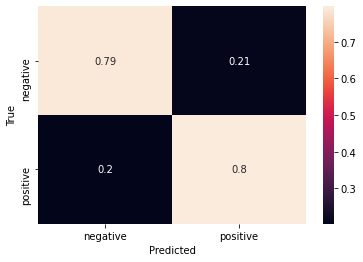

In [15]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
cm = tf.math.confusion_matrix(train_df["polarity"], 
                              get_predictions(estimator, predict_train_input_fn))

# Normalize the confusion matrix so that each row sums to 1.
cm = tf.cast(cm, dtype=tf.float32)
cm = cm / tf.math.reduce_sum(cm, axis=1)[:, np.newaxis]

sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");
